In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
import cv2

from keras import Sequential
from keras.layers import Dense


from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.models import Model

In [2]:
IMAGE_PATH = "../../data/"
FOLDER_PATH = "../../data/"

MODEL = "../models/stage_clf/stage23_enh_manual/stage23_enh_manual.h5"
OUT = "../Other/result.csv"

LABELS = ['stage 2', 'stage 3']
IMG_SIZE = 384
INPUT_DIM = 1280


In [3]:
cnn_model = EfficientNetV2S(weights='imagenet', include_top=False, pooling='avg')

model = Sequential([
        Dense(1024, input_dim=INPUT_DIM, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(len(LABELS), activation='softmax')])

model.load_weights(MODEL)

In [14]:
def enhance_img(img_path):
    img = cv2.imread(img_path)
    data = np.array([img])

    assert len(data.shape) == 4
    assert data.shape[3] == 3  # Check for 3 channels (RGB)

    # My preprocessing:
    data = dataset_normalized(data)
    data = clahe_equalized(data)
    data = adjust_gamma(data, 1.2)
    data = data / 255.  # Reduce to 0-1 range
    plt.imsave('temp.png', data[0], cmap='gray')
    return 'temp.png'

# Normalize over the dataset
def dataset_normalized(imgs):
    imgs_normalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs[i] - np.min(imgs[i])) / (np.max(imgs[i]) - np.min(imgs[i]))) * 255
    return imgs_normalized

# CLAHE (Contrast Limited Adaptive Histogram Equalization) for each channel
def clahe_equalized(imgs):
    assert len(imgs.shape) == 4  # 4D arrays
    assert imgs.shape[3] == 3  # Check for 3 channels (RGB)

    # Create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    imgs_equalized = np.empty(imgs.shape)

    for i in range(imgs.shape[0]):
        for c in range(3):
            # Convert to 8-bit for CLAHE (assuming the input images are 8-bit)
            img_8bit = imgs[i][:, :, c].astype(np.uint8)
            imgs_equalized[i][:, :, c] = clahe.apply(img_8bit)

    return imgs_equalized

# Adjust gamma for each channel
def adjust_gamma(imgs, gamma=1.0):
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        for c in range(3):
            new_imgs[i][:, :, c] = cv2.LUT(np.array(imgs[i][:, :, c], dtype=np.uint8), create_gamma_lut(gamma))
    return new_imgs

# Create a lookup table mapping pixel values [0, 255] to adjusted gamma values
def create_gamma_lut(gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return table

In [5]:
def preprocess_image(path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, 0)
    x = preprocess_input(x)
    return x

In [6]:
def display_result(label, prob, img_path):
    plt.imshow(Image.open(img_path))
    plt.show()
    print(label, f"({100 * prob:.2f}%)")

In [15]:
def predict_image(img_path, enh=False, display=False):
    if enh:
        plt.imshow(Image.open(img_path))
        plt.show()
        img_path = enhance_img(img_path)
        
    x = preprocess_image(img_path)
    x = cnn_model.predict(x, verbose=0)
    probs = model.predict(x, verbose=0)
    pred = np.argmax(probs[0])

    label = LABELS[pred] 
    prob = probs[0][pred]

    if display:
        display_result(label, prob, img_path)
    if enh:
        shutil.remove(img_path)

    return label, prob, 

In [8]:
def predict_folder(folder_path, display=False):
    results = []
    images = os.listdir(folder_path)

    for i in tqdm(range(len(images))):
        image = images[i]
        img_path = os.path.join(folder_path, image)
        label, prob = predict_image(img_path, display)
        results.append((image, label, prob))
    
    return results

In [9]:
def predict_testset(data_path):
    results = []
    folders = os.listdir(data_path)
    
    for folder in folders:
        folder_path = os.path.join(data_path, folder)
        folder_results = predict_folder(folder_path)
        results += folder_results

    return results

In [10]:
def store_results(results):
    d = {'image_name':[], 'label':[], 'prob':[]}

    for result in results:
        d['image_name'].append(result[0])
        d['label'].append(result[1])
        d['prob'].append(result[2])
    
    df = pd.DataFrame(d)
    df.to_csv(OUT)

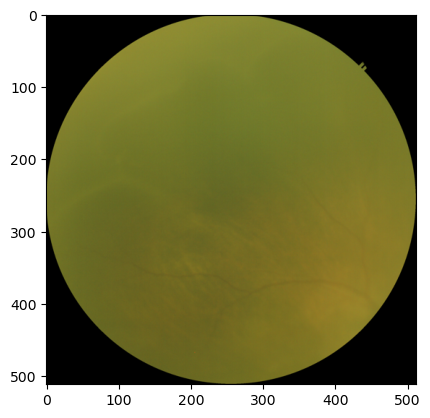

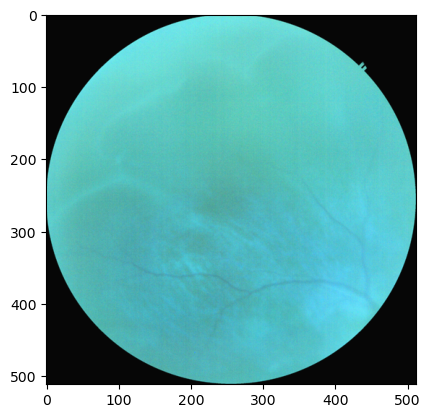

stage 2 (70.89%)


('stage 2', 0.70889544)

In [17]:
# results = predict_testset('../../data/test/')
# store_results(results)

image_id = 'Image_12_0008_2022-10-13_13-22-41-150_1526'
predict_image(f'../../data/stage_clf_img_dataset/2/{image_id}.png', enh=True, display=True)